# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση.
#### Ομάδα 56
#### Γεωργία Μανιφάβα
#### Δημήτρης Βάσιος
#### Ηλίας Ραγκούσης
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 
Ημερομηνία εκφώνησης της άσκησης: 29 Νοεμβρίου 2022

**Θα βρείτε το παρόν σε μορφή jupyter notebook ως συνημμένο στο τέλος της εκφώνησης.**


In [4]:
!pip install --upgrade pip
!pip install h5py
!pip install typing-extensions
!pip install wheel
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib
!pip install --upgrade contractions
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.4 MB/s eta 0:00:00a 0:00:010m
  Attempting uninstall: pip
    Found existing installation: pip 22.1.2
    Uninstalling pip-22.1.2:
      Successfully uninstalled pip-22.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 3.4 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 1.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.1
    Uninstalling joblib-1.0.1:
      Successfully uninstalled joblib-1.0.1
ERROR: pip's dependency resolver

In [5]:
!ls -lh

total 4.0K
---------- 1 root root 263 Jan  6 08:00 __notebook_source__.ipynb


## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [6]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1zo13kUAf-MDMPZmBDxq1FxWtZY01lsxD"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

Κάθε ομάδα θα δουλέψει σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) ως εξής:

1. Κάθε ομάδα του εργαστηρίου νευρωνικών έχει έναν αριθμό στο helios. Θα βάλετε τον αριθμό αυτό στη μεταβλητή team_seed_number στο επόμενο κελί κώδικα.

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [7]:
import numpy as np

# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 56

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1g6F4TCHrs2wgtdOk7D3gtONaeirNt_Vo"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- το dataframe **corpus_df** που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=999` (την χιλιοστή) θα γράψουμε `print(corpus[999])`.

In [8]:
ID = 999
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])
print(corpus_df.loc[ID,:])


['Aina']
['"Musical",  "Drama",  "Romance Film"']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Εκτυπώστε (αρκετές) διαφορετικές περιγραφές ταινιών για να δείτε πιθανά προβλήματα που θα πρέπει να αντιμετωπιστούν.

Τα (ελάχιστα) βήματα καθαρισμού που προτείνουμε είναι:
- μετατροπή όλων των χαρακτήρων σε πεζά,
- αφαίρεση των stopwords. Εδώ σημειώστε ότι για το δεδομένο task του συστήματος συστάσεων που είναι η πρόταση ταινιών ίσως θα είχαν ενδιαφέρον και λίστες stopwords πέραν αυτών της κοινής γλώσσας.
- αφαίρεση σημείων στίξης και ειδικών χαρακτρήρων (special characters). Αυτό δεν γίνεται μόνο με την punkt του NLTK. Θα μπορούσατε να βασιστείτε σε κανονικές εκφράσεις (regular expressions), και
- αφαίρεση πολυ σύντομων συμβολοσειρών.

Προσοχή: το corpus και τα τελικά tokens που θα το αποτελούν θα χρησιμοποιηθούν στη συνέχεια ως κλειδιά για να βρούμε εμφυτεύματα. Για το λόγο αυτό, πρέπει να είστε προσεκτικοί ως προς την εφαρμογή μεθόδων κανονικοποίησης (text normalization) όπως το stemming και το lemmatization.

In [9]:
#necessary imports and downloads
import numpy as np
import string
import nltk
import scipy
import joblib
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from unidecode import unidecode
import collections
import contractions
import re

nltk.download('punkt')
nltk.download('stopwords') 
nltk.download('wordnet') 
nltk.download('rslp')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to /usr/share/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

###  Βοηθητική Συνάρτηση thorough_filter
*Oρισμός της thorough_filter με όρισμα τις λέξεις ενός corpus. Την χρησιμοποιούμε παρακάτω στην preprocessing για να αφαιρέσουμε τα tokens που περιέχουν περισσότερα από ένα σημεία στίξης.*

In [10]:
def thorough_filter(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if not all(pun):
            filtered_words.append(word)
    return filtered_words

print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


#### Stopwords-Aγγλικά ονόματα
*Θα θεωρήσουμε ως επιπλέον stopwords, τα συνηθισμένα αγγλικά αντρικά και γυναικεία ονόματα. Οι ταινίες συνήθως περιέχουν τα ονόματα πρωταγωνιστών. Κάνουμε αυτή την επιλογή ώστε το σύστημα συστάσεων να μην προτείνει ταινίες με άσχετο περιεχόμενο επειδή απλά τυγχάνει οι πρωταγωνιστές να έχουν το ίδιο όνομα σε δύο διαφορετικές ταινίες. Χρησιμοποιούμε το αρχείο names.txt που έχει αντληθεί από το United States Naval Academy και περιέχει αγγλικά ονόματα. Πριν το χρησιμοποιήσουμε για την προεπεξεργασία, μετατρέπουμε το πρώτο γράμμα των ονομάτων σε πεζό. Η διαδικασία φαίνεται στο παρακάτω κελί.*

In [11]:
# Name Stopwords
f = open("/kaggle/input/namestxt/names.txt", "r")
name_stopwords = list(f.read().splitlines())

for i in range (len(name_stopwords)):
    name_stopwords[i] = name_stopwords[i].lower()   

# Common Stopwords
common_stopwords = set(stopwords.words('english'))

# Special Stopwords
special_stopwords = ["film","movie","plot","performance","episode","story","scene","actor",
                     "summary","hero","protagonist","finale","prologue", "director","character","cinema",
                     "one","two","love","man","father","new","young","life","time","family","first","police",
                     "home","mother","house","wife","three","money","car", "son","friend","man","woman","girl",
                     "friend","death","Dr.","Mr.","Mrs","people","town","fight","brother","place","parents", "thing", 
                     "something","kill","killed", "york", "during","work","more"]      
    
# Every Stopword in a union
StopWords = set.union(common_stopwords, special_stopwords, name_stopwords) 

*Παρακάτω ορίζουμε την συνάρτηση προεπεξεργασίας που διατρέχει ολόκληρο το dataset, για να εκτελεστούν παντού τα βήματα καθαρισμού. Παρακάτω παραθέτουμε με σειρά εκτέλεσης τα βήματα προεπεξεργασίας:*
* Πριν εξάγουμε τα tokens, κάνουμε μια ελάχιστη προεπεξεργασία, αφαιρώντας τα πιθανά κενά στην αρχή και στο τέλος των λέξεων, μετατρέπουμε όλες τις λέξεις σε πεζά και διορθώνουμε τις συντομεύσεις φράσεων(don't-->do not)
* Eξάγουμε τα tokens
* Επίσης, αφαιρούμε τα stopwords που δεν προσφέρουν χρήσιμη πληροφορία για τη διάκριση περιεχομένου. Κρίναμε σημαντική και την αφαίρεση ειδικών stopwords που χρησιμοποιούνται αρκετά συχνά στο συγκεκριμένο dataset(από παραδείγματα που τυπώσαμε αλλά και ένα κομμάτι κώδικα για εντοπισμό συχνότερων λέξεων που δεν παρατίθεται εδώ) αλλά και γενικά στις περιγραφές ταινιών και έτσι ορίσαμε την λίστα special_stopwords. Eνοποιούμε τις λίστες common_stopwords και special_stopwords και γεμίζουμε την filtered_words με τις λέξεις που δεν είναι ούτε stopwords, oύτε αγγλικά ονόματα αλλά ούτε και σημεία στίξης.
* Χρησιμοποιούμε τη thorough_filter για περεταίρω φιλτράρισμα στα σημεία στίξης. Αντικαθιστούμε τους special non-ascii characters, που συνήθως είναι τονισμοί ξένων γλωσσών (unidecode). Ακόμα, αντιμετωπίζουμε οποιονδήποτε άλλον ειδικό χαρακτήρα με regular expression(πχ \n - Newline και \t- Horizontal tab)
* Αφαιρούμε τις πολύ σύντομες λέξεις (μήκους μικρότερου του 3)
* Eφαρμόζουμε τον γλωσσικό μεταχηματισμό του Lemmatization, ο οποίος αν και πιο αργός από το stemming, προσφέρει πιο ακριβή αποτελέσματα.

In [12]:
def preprocessing(smr):
    # Save initial summary
    init_smr = smr
    
    # Strip spaces 
    smr = smr.strip() 
    
    # Convert letters to lower
    smr = smr.lower()
    
    # Fix contractions: you're-->you are
    smr = contractions.fix(smr)
    
    # Tokenization
    smr = nltk.word_tokenize(smr)
    
    # Save tokenized summary
    tokenized_smr = smr
    
    # Remove Stopwords & Punctuation  
    smr = [w for w in smr if (w not in StopWords and w not in list(string.punctuation))]
    
    # Extra handling of punctuation with thorough_filter
    smr = thorough_filter(smr)
    
    # Remove non ascii characters 
    smr = [unidecode(w) for w in smr]
    
    # Remove special characters with regular expression (keep only lowercase letters,numbers and underscores)
    smr = [re.sub('[^a-zA-Z0-9-_]', '', w) for w in smr] 
    
    # Remove short words
    smr = [w for w in smr if (len(w)>=3)]
        
    # lemmatization
    smr = [WordNetLemmatizer().lemmatize(w) for w in smr]
        
    # Concatenate tokens back to a sentence
    smr = " ".join(smr)
    
    return init_smr, tokenized_smr, smr
    

### Έλεχος Preprocessing
*Eφαρμόζουμε τη συνάρτηση προεπεξεργασίας στο corpus, που είναι η λίστα με όλες τις περιγραφές των ταινιών του dataset σε μορφή λίστας που περιέχει strings. Τυπώνουμε για έλεγχο ένα παράδειγμα με τα tokens στην αρχή της προεπεξεργασίας, τα tokens στο τέλος της προεπεξεργασίας και το προεπεξεργασμένο corpus με συνένωση των tokens.*

In [13]:
test_corpus = []
for i in range(len(corpus)):
    test_corpus.append(preprocessing(corpus[i]))

In [14]:
print(test_corpus[ID][0])
print("\n")
print(test_corpus[ID][1])
print("\n")
print(test_corpus[ID][2])

Aina is a love story of two hearts and two souls but from two different social classes, one being a daughter of a business tycoon i.e. Rita  and one being a realistic, self-confident and a little bit arrogant poor young man . Rita is a leisure girl whereas Nadeem works as a hotel receptionist and they both fall in love. The differences between Nadeem and Rita's father Seth  arises right from the beginning, esp. when he  criticised Nadeem for his social status and earning capacity, saying his daughter's sari costs 7,500 rupees as compare to his  monthly salary of 750 rupees. But after a struggle by Rita and a threat to her parents that she would suicide if she would not be allowed to marry Nadeem, her father agreed. So both married but Nadeem knew that Seth was not really happy with this marriage. One day Rita's mother  came to her daughter's house, located in a middle class, and offered Nadeem a job in Seth's friend's business firm, which he denied. Not only this, he also angried on Ri

*Εκτελούμε η συνάρτηση preprocessing σε όλα τα summaries των ταινιών και τοποθετούμε τα αποτελέσματα σε νέα λίστα `pr_corpus`*

In [15]:
# Put preprocessed summaries in a new list
pr_corpus = []
for i in range(len(test_corpus)):
    pr_corpus.append(test_corpus[i][2])

Αποθηκεύουμε τα corpus και pr_corpus για μετέπειτα χρήση.

In [16]:
joblib.dump(corpus, 'corpus.pkl')
joblib.dump(pr_corpus, 'pr_corpus.pkl')

['pr_corpus.pkl']

In [17]:
corpus = joblib.load('corpus.pkl')
pr_corpus = joblib.load('pr_corpus.pkl')

## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create sparse tf_idf representation
vectorizer = TfidfVectorizer()
vectorizer.fit(pr_corpus)
#transform sparse matrix to numpy array
corpus_tf_idf_plain = vectorizer.transform(pr_corpus).toarray()

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης.

Προσοχή: ο TfidfVectorizer έχει κάποιες δυνατότητες προεπεξεργασίας παρόποιες με αυτές που αναφέραμε στην προηγούμενη ενότητα. Ό,τι προεπεξεργασία μπορείτε να κάνετε που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά, κάντε την στο πρώτο βήμα της προεπεξεργασίας. Αν χρειάζεται γνώση των συνολικών στατιστικών της συλλογής, κάντε την με τον TfidfVectorizer.

Το TF-IDF δείχνει τη συχνότητα εμφάνισης μίας λέξης συγκρίνοντας τον αριθμό των φορών που μία λέξη εμφανίζεται σε μία περιγραφή με τον αριθμό των περιγραφών στις οποίες εμφανίζεται συνολικά η λέξη. Παρακάτω τυπώνουμε τις διαστάσεις της αναπαράστασης μη βελτιστοποιημένου tf-idf του προεπεξεργασμένου corpus.

In [19]:
print(corpus_tf_idf_plain.shape)

(5000, 40527)


H δεύτερη διάσταση αφορά τις λέξεις κάθε περιγραφής . Ο αριθμός αυτός είνα αρκετά μεγάλος και θα δυσκολέψει την μετέπειτα επεξεργασία. Έτσι, παρακάτω θα μειώσουμε τις διαστατικότητα της αναπαράστασης.

In [20]:
print(corpus_tf_idf_plain)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [21]:
joblib.dump(corpus_tf_idf_plain, 'corpus_tf_idf_plain.pkl') 

['corpus_tf_idf_plain.pkl']

In [22]:
corpus_tf_idf_plain = joblib.load('corpus_tf_idf_plain.pkl')

## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσετε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, θα υπολογίζετε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


*Yπολογίσαμε την ομοιότητα συνημιτόνου κάθε ταινίας με τις υπόλοιπες σύμφωνα με τη σχέση:
`ομοιότητα συνημιτόνου = 1 - απόσταση συνημιτόνου`* <br/>
*Παρακάτω φαίνεται η υλοποίηση της συνάρτησης.*

In [23]:
def content_recommender(target_movie, max_recommendations, corpus_type):
    cos_sim = np.zeros((corpus_type.shape[0]))
    
    #compute cosine similarity
    for i in range(corpus_type.shape[0]):
        cos_sim[i] = 1 - scipy.spatial.distance.cosine(corpus_type[target_movie], corpus_type[i])
        
    #sort the similarities 
    indices = np.argsort(cos_sim)[::1] #sort the similarities in  descending order and return the indices
    sorted_cos = sorted(cos_sim, reverse=True) #sort the similarities in descending order 
    
    #Target movie printing
    print("Target movie:",target_movie)
    print("ID:", target_movie)
    print("Title:", titles[target_movie])
    print("Summary:",corpus[target_movie])
    print("Categories:",categories[target_movie])
    print("_________________________________________________________________________\n")
    print("Max recommendations:",max_recommendations)
    print("_________________________________________________________________________\n")
    #Max recommended movies printing
    for i in range(max_recommendations):
        movie = indices[i+1]
        
        print("Recommendation order:",i+1)
        print("Cosine similarity:", sorted_cos[i+1])
        print("ID:", movie)
        print("Title:", titles[movie])
        print("Summary:", corpus[movie])
        print("Categories:", categories[movie])
        print("____________________________________________________________________\n")

## Έλεγχος συστήματος συστάσεων
Χρησιμοποιούμε τυχαία IDs: 999, 2345, 344
### 1st Recommendation - Σχόλια
*Εδώ βλέπουμε ότι δεν υπάρχει σχεδόν καμία συσχέτιση των 3 συστάσεων σε σχέση με την ταινία επιλογής καθώς η target movie αναφέρεται έχει χαρακτηριστικά Drama, Musical και οι προτάσεις που προκύπτουν παραπέμπουν σε Zombie Film, Action.*

In [24]:
content_recommender(999,3,corpus_tf_idf_plain)

Target movie: 999
ID: 999
Title: ['Aina']
Summary: Aina is a love story of two hearts and two souls but from two different social classes, one being a daughter of a business tycoon i.e. Rita  and one being a realistic, self-confident and a little bit arrogant poor young man . Rita is a leisure girl whereas Nadeem works as a hotel receptionist and they both fall in love. The differences between Nadeem and Rita's father Seth  arises right from the beginning, esp. when he  criticised Nadeem for his social status and earning capacity, saying his daughter's sari costs 7,500 rupees as compare to his  monthly salary of 750 rupees. But after a struggle by Rita and a threat to her parents that she would suicide if she would not be allowed to marry Nadeem, her father agreed. So both married but Nadeem knew that Seth was not really happy with this marriage. One day Rita's mother  came to her daughter's house, located in a middle class, and offered Nadeem a job in Seth's friend's business firm, wh

### 2st Recommendation - Σχόλια
*Εδώ βλέπουμε ότι υπάρχει μία σχετική συσχέτιση της target movie με την 2η σύσταση όσον αφορά το χαρακτηριστικό comedy. H 1η και η 3η πρόταση είναι εντελώς ασυσχέτιστες.*



In [25]:
content_recommender(2345,3,corpus_tf_idf_plain)

Target movie: 2345
ID: 2345
Title: ['Press for Time']
Summary: Norman Shields  is a local newspaper seller in London. He is happy with his current job, but is sent by his grandfather, the Prime Minister , to take up a new job as a newspaper reporter in the fictional seaside town of Tinmouth. During his time in Tinmouth he gets himself into all sorts of trouble while on the job reporting . Later in the film he becomes reporter for the entertainment section of the newspaper and covers a beauty contest which his girlfriend Liz wins. They later return to London together, leaving a more politically settled Tinmouth behind.
Categories: ['"Screwball comedy",  "Comedy of Errors",  "Comedy"']
_________________________________________________________________________

Max recommendations: 3
_________________________________________________________________________

Recommendation order: 1
Cosine similarity: 0.12838949820028245
ID: 2942
Title: ['Melody']
Summary: In this cartoon, Professor Owl teac

### 3st Recommendation - Σχόλια
*Εδώ βλέπουμε ότι μία ομοιότητα της τάξης του 36%  και όντως οι συστάσεις σχετίζονται με την ταινία στόχο ως προς το Drama.*

In [26]:
content_recommender(344, 3, corpus_tf_idf_plain)

Target movie: 344
ID: 344
Title: ['Panakkaran']
Summary: Rajini is a poor man who works in a labour factory. He works only to give his money to his drunkard father  who tortures him for that right from his childhood. Rajini gets a chance to go to work in Vijaykumar's factory. After that he learns that Vijaykumar is his father. How they unite forms the story.
Categories: ['"Drama"']
_________________________________________________________________________

Max recommendations: 3
_________________________________________________________________________

Recommendation order: 1
Cosine similarity: 0.3655834055895403
ID: 2041
Title: ['An American Dream']
Summary:  Stephen Rojack, a war hero, returns home to become a tough-talking television commentator who strongly criticizes the police's inability to put an end to the criminal activities of an organized-crime figure, Ganucci. Separated from his alcoholic wife, Deborah, he goes to her seeking a divorce. A violent argument breaks out, ending

## Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε την για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. 

Ταυτόχρονα, μια αντίρροπη κατά κάποιο τρόπο κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




*Παραπάνω κάναμε fit την TfidfVectorizer στo corpus, **με όλη την  προεπεξεργασία που έχει προηγηθεί** στο dataset. Στη βελτιστοποίηση της συνάρτησης θα προσαρμόσουμε τις παραμέτρους της που αφορούν την προεπεξεργασία των δεδομένων. Συνεπώς, θα δούμε αλλαγές στη διαστατικότητα(με τις default παραμέτρους, η διαστατικότητα είναι 40527), που θα διευκολύνουν την επεξεργασία για την εξαγωγή συστάσεων. Δοκιμάζοντας αρκετές τιμές και παρατηρώντας τα αποτελέσματα της content_recommender για διαφορετικές ταινίες και διαφορετικά max_recommendations, σκοπεύουμε να εντοπίσουμε ένα σύνολο παραμέτρων που επιστρέφουν ι σημασιολογικά παρόμοιες ταινίες. Ως κριτήριο για το αν η content_recommender επιστρέφει ικανοποιητικά αποτελέσματα, διαβάζουμε και συγκρίνουμε τις περιγραφές και τις κατηγορίες των ταινιών που προτείνει. Παρκάτω θα τροποποίησουμε  τις παραμέτρους max_df και min_df. Η max_df αγνοεί τους όρους που εμφανίζονται από ένα ποσοστό και πάνω σε όλα τα κείμενα συνολικά, ενώ η min_df αγνοεί τους πολύ σπάνιους όρους. Δεδομένου ότι έχει προηγηθεί επεξεργασία στα corpus, δε θα αφαιρέσουμε άλλες λέξεις.*


#### Βελιστοποίηση με τροποποίηση των παραμέτρων της TfidfVectorizer

*Aρχικά, τροποποιούμε τις παραμέτρους maxdf και mindf, για να μειώσουμε τη διαστατικότητα και πάρουμε καλύτερες συστάσεις. \
Το κριτήριο βελτιστοποίησης είναι η αξιολόγηση του κατά πόσο η content_recommender προτείνει σημασιολογικά παρεμφερείς ταινίες. Η σημασιολογική εγγύτητα αξιολογείται από τις περιγραφές και από τις κατηγορίες των ταινιών.*

In [27]:
opt_vectorizer = TfidfVectorizer(min_df=0.0008)
opt_vectorizer.fit(pr_corpus)
corpus_tf_idf_optimal = opt_vectorizer.transform(pr_corpus).toarray()
print(corpus_tf_idf_optimal.shape)


(5000, 12222)


### Έλεγχος συστήματος συστάσεων με βελτιστοποίηση
*Χρησιμοποιούμε για ίδια IDs: 999, 2345, 344 για σύγκριση αποτελεσμάτων και δύο ακόμα επιπλέον παράδειγμα.*

### 1st Recommendation - Σχόλια


In [28]:
content_recommender(999,3,corpus_tf_idf_optimal)

Target movie: 999
ID: 999
Title: ['Aina']
Summary: Aina is a love story of two hearts and two souls but from two different social classes, one being a daughter of a business tycoon i.e. Rita  and one being a realistic, self-confident and a little bit arrogant poor young man . Rita is a leisure girl whereas Nadeem works as a hotel receptionist and they both fall in love. The differences between Nadeem and Rita's father Seth  arises right from the beginning, esp. when he  criticised Nadeem for his social status and earning capacity, saying his daughter's sari costs 7,500 rupees as compare to his  monthly salary of 750 rupees. But after a struggle by Rita and a threat to her parents that she would suicide if she would not be allowed to marry Nadeem, her father agreed. So both married but Nadeem knew that Seth was not really happy with this marriage. One day Rita's mother  came to her daughter's house, located in a middle class, and offered Nadeem a job in Seth's friend's business firm, wh

### 2nd Recommendation - Σχόλια


In [29]:
content_recommender(2345,3,corpus_tf_idf_optimal)

Target movie: 2345
ID: 2345
Title: ['Press for Time']
Summary: Norman Shields  is a local newspaper seller in London. He is happy with his current job, but is sent by his grandfather, the Prime Minister , to take up a new job as a newspaper reporter in the fictional seaside town of Tinmouth. During his time in Tinmouth he gets himself into all sorts of trouble while on the job reporting . Later in the film he becomes reporter for the entertainment section of the newspaper and covers a beauty contest which his girlfriend Liz wins. They later return to London together, leaving a more politically settled Tinmouth behind.
Categories: ['"Screwball comedy",  "Comedy of Errors",  "Comedy"']
_________________________________________________________________________

Max recommendations: 3
_________________________________________________________________________

Recommendation order: 1
Cosine similarity: 0.19575946102660824
ID: 4234
Title: ['Foreign Body']
Summary: Banerjee stars as Ram Das, a 

### 3rd Recommendation - Σχόλια

In [30]:
content_recommender(344,3,corpus_tf_idf_optimal)

Target movie: 344
ID: 344
Title: ['Panakkaran']
Summary: Rajini is a poor man who works in a labour factory. He works only to give his money to his drunkard father  who tortures him for that right from his childhood. Rajini gets a chance to go to work in Vijaykumar's factory. After that he learns that Vijaykumar is his father. How they unite forms the story.
Categories: ['"Drama"']
_________________________________________________________________________

Max recommendations: 3
_________________________________________________________________________

Recommendation order: 1
Cosine similarity: 0.22214080633803968
ID: 1937
Title: ['Congkak']
Summary: Kazman is a dedicated husband who, despite his wife Sufiah's protests, decided to buy a bungalow for their family near a lake as a family getaway. Anxious in the new house, Sufiah feels as if someone is watching her. Her daughter Lisa, who would always go downstairs at night to play congkak with someone whom she could only see, compounds he

### 4th Recommendation - Σχόλια

In [31]:
content_recommender(4700,5,corpus_tf_idf_optimal)

Target movie: 4700
ID: 4700
Title: ['Wayward, Crazy, Insane']
Summary: The story centres on the legacy of a dead Indian underworld don , who dies of a heart attack at the beginning of the film. He leaves diamonds worth $10bn at the New York Bank, to be distributed equally between his son Vikrant, his daughter Preeti, and Preeti's husband Guru Gulab Khatri. To claim the diamonds, all three benefactors must be present at the bank or, if dead, their death certificates must be presented. Shortly after the Don's death, Vikrant attempts to eliminate Guru by assassinating the Indian home minister in full view of television cameras while disguised as him. Guru flees to the US disguised as someone else to escape prosecution. Guru moves to the street where Anmol and his family live. Anmol recognizes him from the news. His mother-in-law forces him to go to India, along with his father-in-law, Manilal  to tell Vikrant about Guru and get the reward. But everything turns wrong when Vikrant doesn't g

### 5th Recommendation - Σχόλια

In [32]:
content_recommender(1527,5,corpus_tf_idf_optimal)

Target movie: 1527
ID: 1527
Title: ["The Sovereign's Servant"]
Summary: Tha action takes place at the time of the Swedish-Russian war of 1709. The King of France, Louis XIV, sends two duelists into exile. One of them is ordered to go to the camp of the King, Karl XII, of the Swedes and the other is sent to the camp of the Russian Tsar, Peter the First. Both Frenchmen face various dangers along their way. They witness the grand battle of Poltava from opposite sides. Court plots and romantic adventures stay in the past as both our milksops are plunged head first in the boiling pot of war and the horrors it brings into their lives.
Categories: ['"History",  "Action",  "Adventure",  "War film"']
_________________________________________________________________________

Max recommendations: 5
_________________________________________________________________________

Recommendation order: 1
Cosine similarity: 0.1993925930332352
ID: 1265
Title: ["Doctor Ahrendt's Decision"]
Summary: Dr. Ahren

*Στην πλειοψηφία προτείνονται ταινίες με σημασιολογικά κοινές περιγραφές και παρόμοιες κατηγορίες με τη χρήση της βελτιστοποιημένης αναπαράστασης. Το σύστημα συστάσεων λειτούργησε αρκετά ικανοποιητικά και για 5 συστάσεις για τα IDs  1527 και 4700, όπου πρότεινε ταινίες με βασικούς πυρήνες το Crime Fiction/Advecture/Action/Comedy και Ηistory/Drama αντίστοιχα.\
Δοκιμάζοντας αρκετές τιμές για παραμέτρους της TfidfVectorizer, καταλήξαμε σε καλύτερα αποτελέσματα για min_df=0.0008 και χωρίς να θέσουμε κάποια τιμή στο max_df(επηρέαζε αρνητικά η αλλαγή του, πιθανώς γιατί στην προεπεξεργασία έχουν ήδη αφαιρεθεί πολλά common words)*

## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων



#### Εμφυτεύματα του Gensim-data
Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

In [33]:
!pip install -U gensim
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 21.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1
['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Τα μοντέλα αυτά βρίσκονται στο [αποθετήριο Gensim-data](https://github.com/RaRe-Technologies/gensim-data) όπου μπορείτε να βρείτε και την τεκμηρίωσή τους. Η φόρτωση των μοντέλων αυτών γίνεται με τη συνάρτηση `gensim.downloader.load`.

In [34]:
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

### Σύγκριση μοντέλων `gensim`
*Αρχικά,αγνοήσαμε το word2vec-ruscorpore-300, το οποίο περιείχε ρώσικες λέξεις. Επίσης, απορρίφθηκε το word2vec-google-news-300 που είχε απαγορευτικό μέγεθος(1662ΜΒ) και θα καθυστερούσε πολύ κατά τη χρήση του. Από τα υπόλοιπα μοντέλα με πολλαπλά m, διαλέξαμε εκείνα που είχαν τη μεγαλύτερη διάσταση διανυσμάτων. Παρακάτω γίνεται σύγκριση τριών μοντέλων που θεωρούμε ότι καλύπτουν τις ανάγκες της εφαρμογής.*

In [44]:
corpus1 = api.load('fasttext-wiki-news-subwords-300')
corpus2 = api.load('glove-twitter-200')
corpus3 = api.load('glove-wiki-gigaword-300')

In [45]:
joblib.dump(corpus2, 'corpus2.pkl') 
corpus2 = joblib.load('corpus2.pkl')
joblib.dump(corpus3, 'corpus3.pkl') 
corpus3 = joblib.load('corpus3.pkl')

In [46]:
## συντελεστές ομοιότητας και διαστάσεις για τη λέξη flower για κάθε ένα από τα τρία μοντέλα του gensim
print(corpus1.most_similar('flower'))
print(corpus1['flower'].shape)
print(corpus2.most_similar('flower'))
print(corpus2['flower'].shape)
print(corpus3.most_similar('flower'))
print(corpus3['flower'].shape)

[('flowers', 0.8167291879653931), ('flower-', 0.7359845638275146), ('flowering', 0.7335359454154968), ('flower-pot', 0.731009304523468), ('cut-flower', 0.7299766540527344), ('blossoms', 0.7290408611297607), ('flowerhead', 0.7245753407478333), ('carnation', 0.7160440683364868), ('flower-bearing', 0.705016016960144), ('bloom', 0.7047209739685059)]
(300,)
[('flowers', 0.7406843900680542), ('floral', 0.6247478127479553), ('tree', 0.6217444539070129), ('garden', 0.6090577244758606), ('purple', 0.6054032444953918), ('butterfly', 0.6025518774986267), ('blossom', 0.5981655120849609), ('rose', 0.5979903340339661), ('bouquet', 0.5968906879425049), ('yellow', 0.5892904996871948)]
(200,)
[('flowers', 0.700128972530365), ('petals', 0.5507511496543884), ('floral', 0.5470587015151978), ('blossoms', 0.5127416849136353), ('fruit', 0.501261293888092), ('flowering', 0.5010757446289062), ('roses', 0.5008191466331482), ('buds', 0.4907474219799042), ('blooms', 0.47430336475372314), ('lavender', 0.4719004929

In [47]:
joblib.dump(corpus1, 'corpus1.pkl') 

['corpus1.pkl']

In [48]:
corpus1=joblib.load('corpus1.pkl')

#### Άλλα εμφυτεύματα
Μπορείτε να βρείτε προεκπαιδευμένα εμφυτεύματα και από πηγές εκτός του Gensim. Για παράδειγμα:

- [Google News dataset](https://code.google.com/archive/p/word2vec/). Πρόκειται για προ-εκπαιδευμένα διανύσματα που έχουν εκπαιδευτεί σε μέρος του συνόλου δεδομένων Google News (περίπου 100 δισεκατομμύρια λέξεις). Το μοντέλο περιέχει διανύσματα 300 διαστάσεων για 3 εκατομμύρια λέξεις και φράσεις.
- [Amazon BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html). Το BlazingText δεν είναι μόνο προεκπαιδευμένα εμφυτεύματα αλλα και βελτιστοποιημένες υλοποιήσεις των αλγορίθμων Word2vec για την επεξεργασία κειμένου. Προυπόθεση είναι να δουλέψει κανείς στο SageMaker.

Οι διαδικασίες φόρτωσης embeddings από εξωτερικά δεδομένα μπορεί να είναι ελαφρά διαφορετικές από αυτή του Gensim.



#### Παρατηρήσεις

*   Επαναλαμβάνουμε ότι στην εργασία αυτή δεν μας ενδιαφέρουν τα ίδια τα μοντέλα αλλά το να μπορούμε για μία λέξη του λεξιλογίου μας να μπορούμε να βρούμε το embedding (διάνυσμα) που της αντιστοιχεί στο εκάστοτε προεκπαιδευμένο μοντέλο. 

*   Επίσης, δεν θα χρησιμοποιήσουμε την `Phrases` για να βρούμε bigrams στο dataset μας όπως θα ήταν το ορθότερο, καθώς αυτό θα απαιτούσε την συνέχιση της εκπαίδευσης του μοντέλου σε νέο λεξιλόγιο με πολύ λίγα νέα δεδομένα.


 ### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


#### build_tfw2v

Υλοποιήστε μια συνάρτηση `build_tfw2v` με ορίσματα:
- `corpus` που θα είναι το προεπεξεργασμένο dataset σας,
- `vectors` που θα είναι το μοντέλο που θα σας δίνει τα διανύσματα των εμφυτεύσεων vectors, και 
- `embeddings_size` που θα είναι η διάσταση των εμφυτευμάτων $m$.

H συνάρτηση αυτή θα επιστρέφει ένα νέο corpus που θα είναι ένας πίνακας 5000 (όσες οι ταινίες σας) x $m$ (το η διάσταση των εμφυτευμάτων). Ανάλογα ποιο μοντέλο χρησιμποιείτε για transfer learning ο πίνακας αυτός θα είναι διαφορετικός.

Μπορείτε πλεόν να καλείτε την `content_recommender` με διαφορετικά corpora στο όρισμα `corpus_type`. Σημειώστε ότι στο TFidfVectorizer χρησιμοποιουμε τη σειριακή μορφή των numpy arrays και ίσως σας χρησιμεύσει η `sparse.csr_matrix()` από την Scipy.

#### Υλοποίηση της ζητούμενης συνάρτησης

In [49]:
from scipy.sparse import csr_matrix

def build_tfw2v(smr, vectors, embeddings_size):
    #initialize word vector for every corpus
    W2V_d = np.zeros((len(smr),embeddings_size)) #5000 x m
    #tfidf representations
    opt_vectorizer.fit(smr)
    corpus_tf_idf = vectorizer.transform(smr)
    
    i=0
    #iteration in pre-processed corpus
    for film in smr:
        tokens = [w for w in word_tokenize(film)]#tokenize the corpus of each film
        numerator = np.zeros(embeddings_size)
        denominator = 0
        #iteration in words of each corpus
        for word in tokens:
            #check if the word exists in the Word2Vec pretrained model and 
            #find the pretrained embeddings in the model that is inserted
            if word in vectors.index_to_key and word in vectorizer.vocabulary_:
                w2v_i = vectors[word] #it is vector: 1 x m
                tfidf_i = corpus_tf_idf[i, vectorizer.vocabulary_[word]]#with vectorizer.vocabulary_ we extract the index of word in the sparse array for a movie
                numerator += tfidf_i * w2v_i
                denominator += tfidf_i 
            else:
                continue
        #check if the denominator is zero
        if denominator!=0:
            W2V_d[i,:] = numerator/denominator
            i+=1
        
    return W2V_d #returns a matrix with dimensions: movie number x m
            
    

In [50]:
tfw2v1 = build_tfw2v(pr_corpus, corpus1, 300)
tfw2v2 = build_tfw2v(pr_corpus, corpus2, 200)
tfw2v3 = build_tfw2v(pr_corpus, corpus3, 300)

print(tfw2v1.shape)
print(tfw2v2.shape)
print(tfw2v3.shape)

(5000, 300)
(5000, 200)
(5000, 300)


*Παρακάτω χρησιμοποιούμε τα νέα corpus για δύο τυχαίες ταινίες(IDs: 4800, 2500) και για τα τρία μοντέλα με σκοπό να βρούμε ποια είναι η καλύτερη αναπαράσταση.*

### fasttext-wiki-news-subwords-300

In [51]:
content_recommender(target_movie=4800, max_recommendations = 5, corpus_type = csr_matrix(tfw2v1).toarray())

Target movie: 4800
ID: 4800
Title: ['The Rainbow Thief']
Summary: Rudolf Von Tannen is an eccentric millionaire who cares for no one but his dalmatians. One night he welcomes his guests - all of them related to him, expecting to cash in his fortune once he passes away - to a dinner party. The dogs are fed caviar and the people are given bones to eat. This sends them away in anger. Then Rudolf's predilect brothel service arrives, the Rainbow Girls, big-breasted women dressed with the colors of the rainbow. After dancing and partying with them, Rudolf has a heart attack that leaves him comatose. The relatives gather to argue over the will, but since Rudolf is alive but in a coma, nothing can be done. The relatives suspect that Rudolf will leave all of his fortune to his equally eccentric nephew, Meleagre. Meleagre arrives in time to overhear the back-talk, and walks away unnoticed with his dog Chronos. Five years later, Meleagre and Dima  live together in the sewerline. Chronos has died.

In [52]:
content_recommender(target_movie=2500, max_recommendations = 5, corpus_type = csr_matrix(tfw2v1).toarray())

Target movie: 2500
ID: 2500
Title: ['Jeanne Dielman 23, quai du Commerce, 1080 Bruxelles']
Summary: Jeanne Dielman examines a single mother's regimented schedule of cooking, cleaning and mothering over three days. The mother, Jeanne Dielman , prostitutes herself to a male client daily for her and her son's subsistence. Like her other activities, Jeanne's prostitution is part of the routine she performs every day by rote and is uneventful. But on the second day, Jeanne's routine begins to unravel subtly, as she drops a newly washed spoon and overcooks the potatoes that she's preparing for dinner. These alterations to Jeanne's existence prepare for the climax on the third day, when she unexpectedly has an orgasm with the day's client, after which she stabs him fatally with a pair of scissors.Stanley Cavell on Film, ed. William Rothman, SUNY at Stony Brook Press, 2005, p. 257
Categories: ['"Drama",  "Art film",  "World cinema"']
____________________________________________________________

### glove-twitter-200

In [53]:
content_recommender(target_movie=4800, max_recommendations = 5, corpus_type = csr_matrix(tfw2v2).toarray())

Target movie: 4800
ID: 4800
Title: ['The Rainbow Thief']
Summary: Rudolf Von Tannen is an eccentric millionaire who cares for no one but his dalmatians. One night he welcomes his guests - all of them related to him, expecting to cash in his fortune once he passes away - to a dinner party. The dogs are fed caviar and the people are given bones to eat. This sends them away in anger. Then Rudolf's predilect brothel service arrives, the Rainbow Girls, big-breasted women dressed with the colors of the rainbow. After dancing and partying with them, Rudolf has a heart attack that leaves him comatose. The relatives gather to argue over the will, but since Rudolf is alive but in a coma, nothing can be done. The relatives suspect that Rudolf will leave all of his fortune to his equally eccentric nephew, Meleagre. Meleagre arrives in time to overhear the back-talk, and walks away unnoticed with his dog Chronos. Five years later, Meleagre and Dima  live together in the sewerline. Chronos has died.

In [54]:
content_recommender(target_movie=2500, max_recommendations = 5, corpus_type = csr_matrix(tfw2v2).toarray())

Target movie: 2500
ID: 2500
Title: ['Jeanne Dielman 23, quai du Commerce, 1080 Bruxelles']
Summary: Jeanne Dielman examines a single mother's regimented schedule of cooking, cleaning and mothering over three days. The mother, Jeanne Dielman , prostitutes herself to a male client daily for her and her son's subsistence. Like her other activities, Jeanne's prostitution is part of the routine she performs every day by rote and is uneventful. But on the second day, Jeanne's routine begins to unravel subtly, as she drops a newly washed spoon and overcooks the potatoes that she's preparing for dinner. These alterations to Jeanne's existence prepare for the climax on the third day, when she unexpectedly has an orgasm with the day's client, after which she stabs him fatally with a pair of scissors.Stanley Cavell on Film, ed. William Rothman, SUNY at Stony Brook Press, 2005, p. 257
Categories: ['"Drama",  "Art film",  "World cinema"']
____________________________________________________________

### glove-wiki-gigaword-300

In [55]:
content_recommender(target_movie=4800, max_recommendations = 5, corpus_type = csr_matrix(tfw2v3).toarray())

Target movie: 4800
ID: 4800
Title: ['The Rainbow Thief']
Summary: Rudolf Von Tannen is an eccentric millionaire who cares for no one but his dalmatians. One night he welcomes his guests - all of them related to him, expecting to cash in his fortune once he passes away - to a dinner party. The dogs are fed caviar and the people are given bones to eat. This sends them away in anger. Then Rudolf's predilect brothel service arrives, the Rainbow Girls, big-breasted women dressed with the colors of the rainbow. After dancing and partying with them, Rudolf has a heart attack that leaves him comatose. The relatives gather to argue over the will, but since Rudolf is alive but in a coma, nothing can be done. The relatives suspect that Rudolf will leave all of his fortune to his equally eccentric nephew, Meleagre. Meleagre arrives in time to overhear the back-talk, and walks away unnoticed with his dog Chronos. Five years later, Meleagre and Dima  live together in the sewerline. Chronos has died.

In [56]:
content_recommender(target_movie=2500, max_recommendations = 5, corpus_type = csr_matrix(tfw2v3).toarray())

Target movie: 2500
ID: 2500
Title: ['Jeanne Dielman 23, quai du Commerce, 1080 Bruxelles']
Summary: Jeanne Dielman examines a single mother's regimented schedule of cooking, cleaning and mothering over three days. The mother, Jeanne Dielman , prostitutes herself to a male client daily for her and her son's subsistence. Like her other activities, Jeanne's prostitution is part of the routine she performs every day by rote and is uneventful. But on the second day, Jeanne's routine begins to unravel subtly, as she drops a newly washed spoon and overcooks the potatoes that she's preparing for dinner. These alterations to Jeanne's existence prepare for the climax on the third day, when she unexpectedly has an orgasm with the day's client, after which she stabs him fatally with a pair of scissors.Stanley Cavell on Film, ed. William Rothman, SUNY at Stony Brook Press, 2005, p. 257
Categories: ['"Drama",  "Art film",  "World cinema"']
____________________________________________________________

*Συγκρίνοντας τα παραπάνω αποτελέσματα των τριών μοντέλων, συμπεραίνουμε ότι με το `fastest-wiki-news-subwords-300` οι συστάσεις είχαν τις καλύτερες τιμές ομοιότητας συνημιτόνου(>0.9) και ήταν πιο κοντά σημασιολογικά με τις ταινίες στόχους. Συνεπώς, θα θεωρήσουμε ως βέλτιστη αναπαράσταση μέχρι τώρα εκείνη που προκύπτει από αυτό το μοντέλο και θα τη χρησιμοποιήσουμε παρακάτω.*

In [57]:
joblib.dump(tfw2v1,'tfw2v1.pkl')
#joblib.dump(tfw2v2,'tfw2v2.pkl')
#joblib.dump(tfw2v3,'tfw2v3.pkl')

['tfw2v1.pkl']

In [58]:
tfw2v1 =joblib.load('tfw2v1.pkl')
#tfw2v2 =joblib.load('tfw2v2.pkl')
#tfw2v3 =joblib.load('tfw2v3.pkl')

## Ανάλυση αποτελεσμάτων

### Σύστημα συστάσεων βασισμένο μόνο στο tfidf

- Σε markdown περιγράψτε τι προεπεξεργασία κάνετε στα κείμενα και γιατί.

- Περιγράψτε πως προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. 

- [Cherry-picking:](https://www.wikiwand.com/en/Cherry_picking) Δώσετε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (τουλάχιστον 5) και σχολιάστε.

- [Nit-picking:](https://en.wikipedia.org/wiki/Nitpicking) Δώστε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν κακά αποτελέσματα και σχολιάστε.

- Ποια είναι συνολικά τα πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf;

**Προεπεξεργασία κειμένου**\
Αναγράφονται πληροφορίες παραπάνω.

**Βελτιστοποίηση TfidfVectorizer**\
Βασικός μας στόχος κατά την βελτιστοποίηση του TfidVectorizer ήταν η σημαντική μείωση της διαστατικότητας του corpus και αυτό το πετυχαίνουμε με τις δύο παραμέτρους df_min και df_max που τις προσαρμόζουμε αναλόγως.

**Cherry-picking**\
Επιλέγουμε τα παρακάτω 5 IDs τα οποία επιστρέφουν καλά αποτελέσματα.

In [927]:
# ID - 45
content_recommender(45, 3, corpus_tf_idf_optimal)

Target movie: 45
ID: 45
Title: ['Mermaids']
Summary: Mermaids is narrated in the first person by Charlotte Flax, a 15-year-old girl living with her eccentric mother, Rachel , and sister, Kate. Kate calls her mother by her given name. The narration begins in early fall 1963, just as Rachel's latest fling with her married employer ends and she decides to relocate once again. This time, she and the girls move into a new home near a convent in the small town of Eastport, Massachusetts. Charlotte has an obsession with Catholicism and idolizes the nuns living in the convent. She is always reminded by Rachel, "Charlotte, we're Jewish." Kate, on the other hand, loves oceans and swimming and apparently learned to do so while she was a baby. She won many swimming competitions. In the new town, Charlotte is especially interested in Joe, the 26-year-old handsome caretaker of the convent and local school bus driver while Rachel falls in love with a local shop owner named Lou. After the assassinatio

In [928]:
# ID - 58
content_recommender(58, 3, corpus_tf_idf_optimal)

Target movie: 58
ID: 58
Title: ['Boys and Girls']
Summary: Jennifer Burrows and Ryan Walker meet as teenagers aboard an airplane and quickly find out that they both have different views on life. Several years later, Ryan is mascot to his high school, while Jennifer is elected Homecoming Queen of hers. During the halftime ceremony between the two schools, Ryan is chased by the rival mascots and loses his mascot head, only to find it run over by Jennifer's ceremonial car. Jennifer later finds Ryan and tries to console him about his costume. The two, again realizing they are too different and do not get along as friends, part ways once more. A year later, Ryan and Jennifer are students at UC Berkeley. Ryan is in a steady, structured relationship with his high school sweetheart, Betty and Jennifer is in a wild, spontaneous, sex-crazed relationship with a musician. Ryan meets his roommate Hunter , who uses deception and lies as a way to meet women. Jennifer moves in with her best friend Amy

In [929]:
# ID - 59
content_recommender(59, 3, corpus_tf_idf_optimal)

Target movie: 59
ID: 59
Title: ['Alaska Highway']
Summary: The film begins with the attack on Pearl Harbor. Alaska at the time was weakly defended. Canada had already built the northwest staging route; a series of airfields spread across northwestern Canada. The decision is made to build a highway to Alaska. The workers are divided into three starting camps, Fort Nelson BC., Skagway Alaska, and Valdez Alaska. The workers from Fort Nelson BC begin building a highway north. The workers in Skagway are transported by the White Pass and Yukon Route railway to Whitehorse. From Whitehorse they begin building a road north and south. The workers in Valdez Alaska move to a point inland and begin building a road towards Fairbanks and Whitehorse. The movie goes on to show some amazing footage of bulldozers building the highway. The black troops arrive and all work hard building the highway. The highway is opened to traffic. The truck drivers find that the road is better to drive than expected. How

In [930]:
# ID - 153
content_recommender(153, 3, corpus_tf_idf_optimal)

Target movie: 153
ID: 153
Title: ['Tom Sawyer']
Summary: After arguing with his sweetheart, Becky Thatcher, Tom Sawyer seeks solace from his friend Huck Finn, who tells him about a mysterious cure for warts that requires them to visit the local cemetery at midnight. While there they witness a murder committed by Injun Joe, who convinces Muff Potter, who also was there but in an inebriated state, that he is guilty of the crime. Tom and Huck promise each other they will not divulge what they have seen. When Tom is caught lying about stealing his half-brother Sid's crabapples, his Aunt Polly punishes him by making him whitewash the fence on a Saturday morning. The boy leads his friends to believe he is enjoying the task, and before long they are giving him their treasures in exchange for the privilege of joining in the fun. Together with Huck and Joe Harper, Tom runs away from home to become a pirate. The three set off on a raft to Jacksons Island in the Mississippi River, where they rema

In [931]:
# ID - 345
content_recommender(345, 3, corpus_tf_idf_optimal)

Target movie: 345
ID: 345
Title: ['Arizona Sky']
Summary: Arizona Sky is a romantic story of two high school buddies who reconnect with desire in their hearts. As the film opens, the teenegers Kyle  and Jake  are getting together for what appears to be a regular ritual of sleeping under the desert stars. The passions of first love are evident in these two young men. They eat some supper and then curl up on blankets for an evening of necking in the back of Kyle’s truck. This happy interlude is at an end, as Jake is set to move with his dad to the big city. 18 years pass and the film picks up with an adult Jake  now a successful film producer with a stressed and loveless life. After an anxiety attack, Jake’s assistant Brian  urges him to take a break from all stresses for the first time in years, encouraging him that it's time to take a vacation and step back from his troubles. This is seconded by Jake's friend Steve , who agrees to accompany Jake to his hometown in Arizona to help him f

**Nit-picking**\
*Επιλέγουμε τα παρακάτω 5 IDs τα οποία δεν επιστρέφουν καλά αποτελέσματα.*

In [932]:
# ID - 345
content_recommender(56, 3, corpus_tf_idf_optimal)

Target movie: 56
ID: 56
Title: ['Tampopo']
Summary: A pair of truck drivers, the experienced Goro  and a young sidekick named Gun , stop at a decrepit roadside ramen  shop. Outside, Goro rescues a boy who is being beaten up by three schoolmates. The boy, Tabo, turns out to be the son of the widowed owner of the struggling business, Tampopo . When a customer called Pisken  harasses Tampopo, Goro invites him and his men to step outside. Goro puts up a good fight, but is knocked out and wakes up the next morning in Tampopo's home. When Tampopo asks their opinion of her noodles, Goro and Gun tell her they are not very good. After Goro gives her some advice, she asks him to become her teacher. They decide to turn her establishment into a paragon of the "art of noodle soup making". Goro takes her around and points out the strengths and weaknesses of her competitors. She still cannot get the broth just right, so Goro brings in the "old master"  and his superlative expertise. When they rescue 

In [933]:
# ID - 1114
content_recommender(1114, 3, corpus_tf_idf_optimal)

Target movie: 1114
ID: 1114
Title: ['Suburban Girl']
Summary:  Sarah Michelle Gellar stars as Brett Eisenberg, an ambitious yet unconfident young New York assistant book editor living in the literary hotbed of Manhattan's Upper East Side. Struggling to become a full-fledged editor, a task made harder after her mentor and boss is fired and replaced by Faye Falkner , Brett meets the notorious and much older publishing playboy Archie Knox . After spending time with him she realises how unhappy she is with her immature boyfriend Jed  and breaks off their relationship in order to pursue one with Archie. Archie is revealed to have several issues such as being an alcoholic, although he is almost three years sober; suffering from diabetes; and having an estranged daughter. The age-gap between Brett and him is made clear through their different lifestyles, such as his lack of understanding how to use a Blackberry and Brett taking him to a candy shop. Although this does not affect their relation

In [936]:
# ID - 3476
content_recommender(3476, 3, corpus_tf_idf_optimal)

Target movie: 3476
ID: 3476
Title: ['Ice Station Zebra']
Summary: A satellite reenters the atmosphere and ejects a capsule which parachutes to the Arctic, coordinates 85N 21W . During an ice storm, a figure soon approaches, guided by a homing beacon, while a second individual secretly watches from nearby. The scene shifts to Commander James Ferraday , captain of the U.S. nuclear attack submarine USS Tigerfish , stationed at Holy Loch, Scotland. He is ordered by Admiral Garvey  to rescue the personnel of Drift Ice Station Zebra, a British civilian scientific weather station moving with the ice pack. However, the mission is actually a cover for a highly classified assignment. Ferraday welcomes aboard British intelligence agent Mr. "Jones"  and a Marine platoon. While underway, a SH-2 Sea Sprite helicopter delivers combat commander Captain Anders , who takes command of the Marines, and Boris Vaslov , an amiable Russian defector and spy, who is a trusted colleague of Jones. The Tigerfish m

In [935]:
# ID - 778
content_recommender(778, 3, corpus_tf_idf_optimal)

Target movie: 778
ID: 778
Title: ['The Cable Guy']
Summary: After a failed marriage proposal to his girlfriend Robin Harris , Steven M. Kovacs  moves into his own apartment after they agree to spend some time apart. Enthusiastic cable guy Ernie "Chip" Douglas , a man with a lisp, installs his cable. Taking advice from his friend Rick , Steven bribes Chip to give him free movie channels, to which Chip agrees. Before he leaves, Chip gets Steven to hang out with him the next day and makes him one of his "preferred customers". As promised, Chip arrives the next day, where he takes Steven to the satellite dish responsible for sending out television. Steven tells his problems with Robin to Chip, who tells him to admit his faults to Robin and invite her over to watch Sleepless in Seattle, which is running on HBO the next night. Steven takes Chip's advice, and Robin agrees to watch the movie with him. The next day, Chip begins acting more suspicious, "running into" Steven and his friends at th

In [937]:
# ID - 1114
content_recommender(726, 3, corpus_tf_idf_optimal)

Target movie: 726
ID: 726
Title: ['Kowarekake no Orgel']
Summary: Kowarekake no Orgel begins in medias res with a look at the two main characters, Keiichirō and Flower, sitting in a van in the rain. It then flashes back to the beginning, showing Keiichirō taking shelter from the rain near a trash heap next to which a small girl is sitting in a chair with a sunflower, unconscious. After second thoughts he decides to pick her up and takes her to a technical specialist. The scene reveals that the girl is an older model of a popular line of service androids, called Parents, who is broken. Because she is an older model, the specialist says she cannot be fixed, and provides Keiichirō with the necessary sticker to dispose of her. Keiichirō leaves her among some junk in his house before going to sleep, intending to throw her out the following day. During the night, the girl begins functioning and finds herself in a strange house with no memory of the past. When Keiichirō comes downstairs the f

**Πλεονεκτήματα:**
* Εύκολο στον υπολογισμό
* Έχουμε έναν τρόπο για να εξάγουμε τους πιο περιγραφικούς όρους σε ένα έγγραφο
* Μπορούμε εύκολα να υπολογίσουμε την ομοιότητα μεταξύ 2 εγγράφων\

**Μειονεκτήματα:**
* Το TF-IDF βασίζεται στο μοντέλο bag-of-words (BoW), επομένως δεν καταγράφει τη θέση στο κείμενο, τη σημασιολογία, τις συνυπάρχουσες περιπτώσεις σε διαφορετικά έγγραφα κ.λπ.
* Είναι χρήσιμο μόνο ως χαρακτηριστικό λεξιλογικού επιπέδου

### Σύγκριση και σχολιασμός με recommenders βασισμένων στο Word2Vec

- Υλoποιήστε recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα. Χρησιμοποιήστε παραδείγματα για να υποδείξετε δυνατά και αδύναμα σημεία τους.

- Μπορείτε να σχολιάσετε τα recommenders που βασίζονται στο Word2Vec σε σχέση με το απλό μοντέλο tfidf, εξετάζοντας τις συστάσεις για ίδια ID.

- Μπορείτε επίσης να εξετάσετε συγκριτικά τα Word2Vec recommenders μεταξύ τους και πάλι βασιζόμενοι σε παραδείγματα.

- Οι παρατηρήσεις σας θα βασίζονται στην ανάλυση των ποιοτικών χαρακτηριστικών που είναι η σειρά και το σύνολο των συστάσεων. Ωστόσο, μπορείτε να συμπεριλάβετε και ποσοτικά χαρακτηριστικά όπως τους χρονους loading και συγκρότησης του corpus αλλά και της διαστατικότητας $m$.

Χρησιμοποιήστε όποια μορφή reporting κρίνετε καταλληλότερη: κείμενο, πίνακες, διαγράμματα.


* Παρατηρούμε πως οι recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα παρουσιάζουν πολύ καλά αποτελέσματα και για ταινίες στόχους, για τις οποίες είχαμε καλές προτάσεις καθώς επίσης και για τις ταινίες-στόχους, όπου δεν είχαμε συναφείς με το περιεχόμενο προτάσεις. Επιπλέον, απαλείφθηκαν και οι προτάσεις ταινιών με εκτενείς περιγραφές που θεωρούνταν σχετικές μόνο και μόνο για τον αυξημένο αριθμό λέξεών τους. Tα αποτελέσματα των recommenders αυτών εξακολουθούσαν να είναι σχετικά και για αυξημένο αριθμό max recommendations.

* Παρατηρούμε πως οι ταινίες που προτείνονται από τους word2vec recommenders είναι πάντα σχετικές με την ταινία στόχο, εμφανίζοντας πολύ υψηλό cosine similarity. To μόνο που αλλάζει βελτιστοποιοώντας τις παραμέτρους είναι η σειρά με την οποία προτείνονται οι ταινίες, ούτως ώστε η προτεραιότητα παρουσίασής τους να είναι πιο συμβατή με την ταινία στόχο.

## Πρακτικό tip - persistence αντικειμένων με joblib.dump

Καθώς στην δεύτερη εργασία καλείστε να δημιουργήσετε διάφορα corpora των οποίων η δημιουργία παίρνει χρόνο, υπάρχει ένας εύκολος τρόπος να αποθηκεύουμε μεταβλητές σε dump files και να τις διαβάζουμε απευθείας.

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα.

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [ ]:
import joblib

joblib.dump(corpus_tf_idf_plain, 'corpus_tf_idf_plain.pkl') 



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [ ]:
!ls -lh

και μπορούμε να τα διαβάσουμε με `joblib.load`

In [ ]:
corpus_tf_idf_plain = joblib.load('corpus_tf_idf_plain.pkl')
print(corpus_tf_idf_plain)

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτα σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [59]:
#Χρησιμοποιούμε το βέλτιστο corpus από την εφαρμογή 1, που προέκυψε από το μοντέλο fasttext-wiki-news-subwords-300 του gensim.
my_best_cospus = tfw2v1

In [60]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

In [61]:
final_set = build_final_set(mycorpus = tfw2v1)

Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και ο θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

In [62]:
final_set.shape

(5000, 622)

In [63]:
tfw2v1.shape

(5000, 300)

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [64]:
# install somoclu
!pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 9.5 MB/s eta 0:00:00:00:010:010m
  Preparing metadata (setup.py) ... done
  Created wheel for somoclu: filename=somoclu-1.7.5.1-cp37-cp37m-linux_x86_64.whl size=287943 sha256=1cfddb6d1db379342ff5be7b42d231f627d1c076f2834922a916ffafcdce05a6
  Stored in directory: /root/.cache/pip/wheels/46/b8/8f/c9f872f527c869d077f372ca265aa78b2b4157ccca484e55da
Successfully built somoclu


Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

In [65]:
n_rows, n_columns = 10, 10
n_epochs = 100
data = final_set[:2000,:]

som=somoclu.Somoclu(n_columns, n_rows, compactsupport = False)

%time som.train(data, epochs = n_epochs)

CPU times: user 33.1 s, sys: 80.8 ms, total: 33.1 s
Wall time: 8.38 s



## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [66]:
bmus = som.bmus
unique_bmus, indices = np.unique(bmus, return_inverse = True,axis=0)
#check the length and the content of the returned arrays
print(bmus.shape)
print("The number of the unique bmus:", len(unique_bmus))
print(unique_bmus)
print(len(indices))

(2000, 2)
The number of the unique bmus: 89
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [0 6]
 [0 7]
 [0 8]
 [0 9]
 [1 0]
 [1 1]
 [1 2]
 [1 4]
 [1 6]
 [1 7]
 [1 8]
 [1 9]
 [2 0]
 [2 1]
 [2 2]
 [2 5]
 [2 6]
 [2 7]
 [2 8]
 [2 9]
 [3 0]
 [3 2]
 [3 4]
 [3 6]
 [3 7]
 [3 8]
 [3 9]
 [4 0]
 [4 1]
 [4 2]
 [4 3]
 [4 4]
 [4 5]
 [4 7]
 [4 8]
 [4 9]
 [5 0]
 [5 1]
 [5 2]
 [5 4]
 [5 5]
 [5 6]
 [5 7]
 [5 9]
 [6 0]
 [6 1]
 [6 2]
 [6 3]
 [6 4]
 [6 5]
 [6 6]
 [6 7]
 [6 8]
 [6 9]
 [7 0]
 [7 1]
 [7 2]
 [7 3]
 [7 4]
 [7 5]
 [7 7]
 [7 8]
 [7 9]
 [8 0]
 [8 1]
 [8 2]
 [8 3]
 [8 4]
 [8 5]
 [8 6]
 [8 7]
 [8 8]
 [8 9]
 [9 0]
 [9 1]
 [9 2]
 [9 3]
 [9 4]
 [9 5]
 [9 6]
 [9 7]
 [9 8]
 [9 9]]
2000



## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


Επιλέγουμε στον αρχικό χάρτη να χρησιμοποιήσουμε k=20 για τον KMeans.

In [67]:
from sklearn.cluster import KMeans

n_clusters=20
algo = KMeans(n_clusters)
som.cluster(algorithm=algo)


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [68]:
joblib.dump(som, 'som.pkl')
som = joblib.load('som.pkl')

In [69]:
bmus = som.bmus
unique_bmus, indices = np.unique(bmus, return_inverse = True,axis=0)

n_clusters=20
algo = KMeans(n_clusters)
som.cluster(algorithm=algo)


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



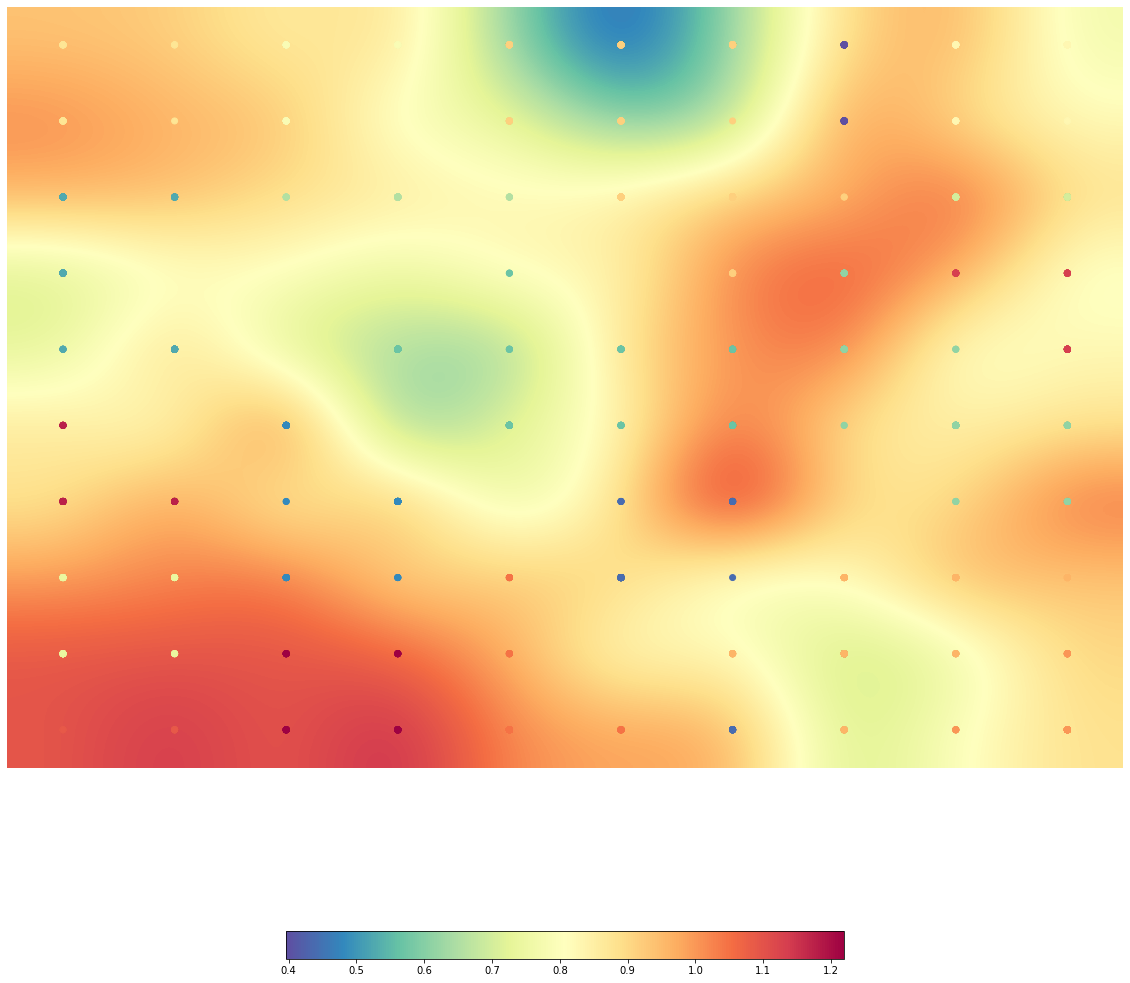

Clusters: [[11 11  9  9 12 12 12  0 10 10]
 [11 11  9  6 12 12 12  0 10 10]
 [ 3  3  6  6  6 12 12 12  7  7]
 [ 3  3  6  4  4 12 12  5 17 17]
 [ 3  3  4  4  4  4  4  5  5 17]
 [18  2  2  4  4  4  4  5  5  5]
 [18 18  2  2  4  1  1  1  5  5]
 [ 8  8  2  2 15  1  1 13 13 13]
 [ 8  8 19 19 15 15 13 13 13 14]
 [16 16 19 19 15 15  1 13 14 14]]
Clusters sorted by increasing number of neurons:
Cluster Index
Number of neurons
[ 0 16  7 17 14 18  9  8 10 11 19 15  6  3  2  1 13  5 12  4]
[ 2  2  2  3  3  3  3  4  4  4  4  5  5  6  6  6  7  8 11 12]


In [70]:
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(20,20))

print("Clusters:", som.clusters)

labels, counts = np.unique(som.clusters, return_counts=True)
sorted_indices = np.argsort(counts) #increasing sort

print("Clusters sorted by increasing number of neurons:",)
print("Cluster Index\nNumber of neurons")
print(labels[sorted_indices])
print(counts[sorted_indices])

Ο χάρτης έχει κυρίως κόκκινες περιοχές, γι' αυτό θα αυξήσουμε τους νευρώνες του grid.
Παρακάτω δημιουργούμε ένα grid 35x35.

Για την παράμετρο k της KMeans, επιλέξαμε τον αριθμό 25, με βάση του πόσα clusters θα πρέπει να υπάρχουν σύμφωνα με τον χάρτη παρακάτω. Παρατηρούμε ότι ήδη κάποια clusters είναι αρκετά εκτεταμένα σε σχέση με άλλα. Προτιμάμε αυτή την τιμή και όχι μεγαλύτερη, διότι διαφορετικά θα υπάρχει μεγάλος κατακερματισμός χωρίς ουσιώδη αποτελέσματα.

In [155]:
n_rows, n_columns = 30, 30
n_epochs = 100
data = final_set[:5000,:]

som_better=somoclu.Somoclu(n_columns, n_rows, compactsupport = False)

%time som_better.train(data, epochs = n_epochs)

bmus_better = som_better.bmus
unique_bmus_better, indices_better = np.unique(bmus_better, return_inverse = True,axis=0)

n_clusters=25
algo = KMeans(n_clusters)
som_better.cluster(algorithm=algo)

CPU times: user 12min 45s, sys: 1.37 s, total: 12min 46s
Wall time: 3min 21s


In [156]:
joblib.dump(som_better,'som_better.pkl')
som_better = joblib.load('som_better.pkl')

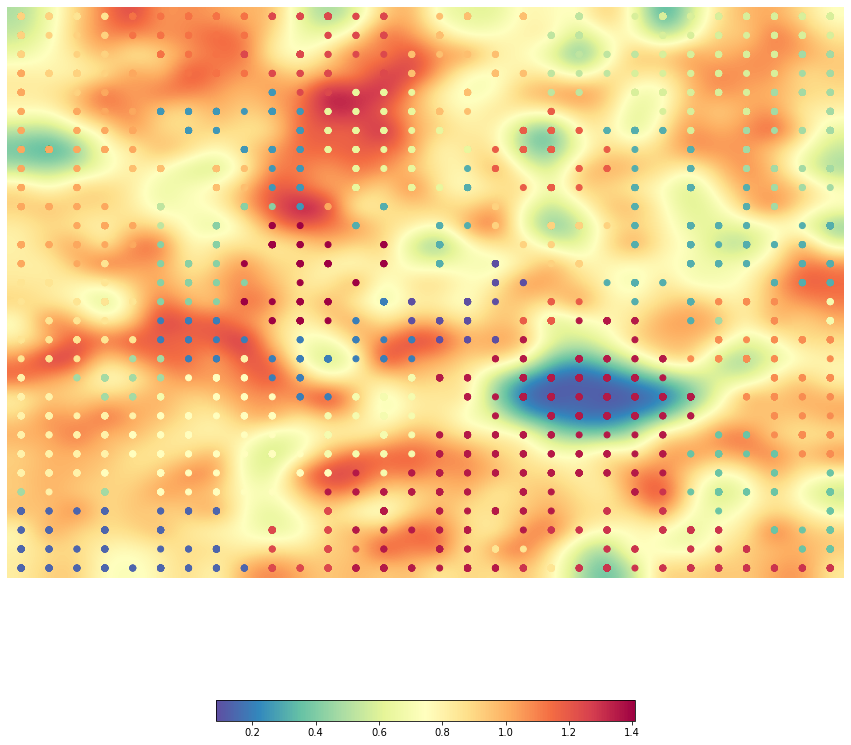

Clusters: [[15 15 14 14 19 19 19 19 19 21 21 21 21 21  8 16 16 16 16  8  8  8  9  9
   9  9  9  9  9  9]
 [15 15 15 15 19 19 19 19 19 21 21 21 21 21 16 16 16 16 16  8  8  8  9  9
   9  9  9  9  9  9]
 [15 15 15 15 19 19 19 19 21 21 21 21 21 21 16 16 16 16 16  8  8  8  8  9
   9  9  9  9  7  7]
 [17 15 15 15 17 19 19 19 19 21 21 21 21 21 16 16 16 16 16  8  8  8  9  9
   9  9  9  9  7  7]
 [17 17 15 17 17  3  3  3  3  3 21 21 10 10 10 16 16 16  8  8  8  9  9  9
   9  9  9  7  7  7]
 [17 17 17 17 17  3  3  3  3  3  3 10 10 10 10 16 16  4 20 20 20  4  9  9
   9  9  9  7  7  7]
 [17 17 17 17 17  3  3  3  3  3  3 10 10 10 10 10 10 20 20 20 20  4  4  4
   9  9  7  7  7  7]
 [17 17 17 17 17 16  3 16  3  3  3 10 10 10 10 10 10 20 20 20 20 20  4  4
   4  7  7  7  7  7]
 [17 17 17 17 16 16 16 16 16  3  3 10 10 10 10 10  4 20 20 20 20 20  4  4
   4  4  7  7  7  7]
 [17 17 17 17 17  8 16 16 16  3  3 10 10 10 10 10  4  4 20 20 20  4  4  4
   4  4  4  7  7  7]
 [17 17 17 17 17  8  8  6  6  6  3 17  4

In [157]:
som_better.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

print("Clusters:", som_better.clusters)

labels, counts = np.unique(som_better.clusters, return_counts=True)
sorted_indices = np.argsort(counts) #increasing sort

print("Clusters sorted by increasing number of neurons:",)
print("Cluster Index\nNumber of neurons")
print(labels[sorted_indices])
print(counts[sorted_indices])


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [158]:
def print_categories_stats(ids):
    categories_list=[]
    
    for movie in ids:
        cats = categories[movie][0]
        movie_categories = cats.split(",")
        movie_categories = [cat.strip() for cat in movie_categories]
        
        categories_list.extend(movie_categories)
    
    labels, counts = np.unique(categories_list, return_counts = True)
    sorted_indices = np.argsort(counts)[::-1] #sort in decreasing order

    stats = dict(zip(labels[sorted_indices], counts[sorted_indices]))
    
    print('Overall Cluster Genres stats:')
   # print(stats)
    return stats

In [159]:
def print_cluster_neurons_movies_report(cluster, som_model, ubmus):
    coordinates=np.where(som_model.clusters==cluster)[::-1] #στήλη-σειρά
    bmus_array=np.column_stack(coordinates)
    #print(bmus_array)
  
    idx =[]
    for bmu in bmus_array:
        if bmu in ubmus:
            idx.append(bmu)
            
    idx = np.asarray(idx)
   # print(idx)
    return idx

Η neuron_movies_report επιστρέφει το αποτέλεσμα της print_categories_stats για τις ταινίες που αντιστοιχίζονται οι νευρώνες που προκύπτουν από την print_cluster_neurons_movies_report αν την καλέσουμε για ένα cluster.

In [160]:
def neuron_movies_report(neurons):
    movies=[]
    for neuron in neurons:
        movies.extend(np.where(unique_bmus_better == neuron)[0])
        
    return print_categories_stats(movies)

Παράθεση ενός παραδείγματος για σημασιολογική ερμηνεία του cluster 15.

In [161]:
neuron_movies_report(print_cluster_neurons_movies_report(3, som_better, unique_bmus_better))

Overall Cluster Genres stats:


{'"Drama"': 457,
 '"Comedy"': 313,
 '"Romance Film"': 190,
 '"Action"': 181,
 '"World cinema"': 180,
 '"Thriller"': 179,
 '"Horror"': 141,
 '"Action/Adventure"': 135,
 '"Family Film"': 114,
 '"Adventure"': 112,
 '"Black-and-white"': 111,
 '"Indie"': 109,
 '"Short Film"': 101,
 '"Crime Fiction"': 99,
 '"Romantic drama"': 91,
 '"Animation"': 73,
 '"Musical"': 70,
 '"Fantasy"': 68,
 '"Comedy film"': 57,
 '"Science Fiction"': 55,
 '"Silent film"': 53,
 '"Japanese Movies"': 52,
 '"Romantic comedy"': 50,
 '"Documentary"': 48,
 '"Western"': 47,
 '"Crime Thriller"': 45,
 '"War film"': 45,
 '"Parody"': 43,
 '"Mystery"': 37,
 '"Comedy-drama"': 36,
 '"Sports"': 33,
 '"Action Thrillers"': 31,
 '"Bollywood"': 29,
 '"Television movie"': 29,
 '"Coming of age"': 29,
 '"Chinese Movies"': 28,
 '"Filipino Movies"': 28,
 '"Supernatural"': 28,
 '"Cult"': 26,
 '"Film adaptation"': 26,
 '"Teen"': 25,
 '"Family Drama"': 25,
 '"Road movie"': 23,
 '"Slasher"': 22,
 '"Slapstick"': 21,
 '"Period piece"': 21,
 '"B

 ## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.


#### Tα παραπάνω tips για SOM και clustering, εφαρμόσθηκαν στην ενότητα Οπτικοποίηση U-matrix, clustering και μέγεθος clusters του notebook, όπου προέκυψε το τελικό som_better, πάνω στο οποίο στηρίχθηκε το clustering.



## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.


Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.


### Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.

*Θεωρούμε ότι ένα cluster χαρακτηρίζεται από τις 6 πιο συχνές κατηγορίες των ταινιών που περιλαμβάνει.*

In [162]:
# εύρεση top και bottom κατηγοριών 

categ_freq = print_categories_stats(range(len(data)))
                                    
print("most frequent categories:",list(categ_freq.items())[:8])
print("least frequent categories:",list(categ_freq.items())[-5:])

Overall Cluster Genres stats:
most frequent categories: [('"Drama"', 2247), ('"Comedy"', 1246), ('"Thriller"', 807), ('"Romance Film"', 769), ('"Action"', 699), ('"World cinema"', 599), ('"Crime Fiction"', 520), ('"Horror"', 482)]
least frequent categories: [('"Mondo film"', 1), ('"Dogme 95"', 1), ('"Malayalam Cinema"', 1), ('"Libraries and librarians"', 1), ('"Law & Crime"', 1)]


*Έτσι, παρακάτω θα τυπώσουμε οργανωμένα για το καθε cluster:τις 6 top και τις 5 bottom κατηγορίες του και τις συχνότητες εμφάνισεις τους.*

In [163]:
from itertools import islice

def nodes_in_cluster(k):
    total_nodes=[]
    for i in range(k):
        freqs =  neuron_movies_report(print_cluster_neurons_movies_report(i, som_better, unique_bmus_better))
        total_nodes.append(sum(freqs.values()))
        print("total_nodes of cluster:", i,"are", sum(freqs.values()))
        print("top 5 categories of cluster", i, "are", list(freqs.items())[:8])
        print("bottom 5 categories of cluster", i, "are",list(freqs.items())[-5:],"\n")

In [164]:
nodes_in_cluster(25)

Overall Cluster Genres stats:
total_nodes of cluster: 0 are 2515
top 5 categories of cluster 0 are [('"Drama"', 325), ('"Comedy"', 199), ('"Adventure"', 103), ('"Romance Film"', 102), ('"Family Film"', 82), ('"Thriller"', 79), ('"Black-and-white"', 76), ('"Action"', 75)]
bottom 5 categories of cluster 0 are [('"Sci-Fi Horror"', 1), ('"Beach Film"', 1), ('"Jungle Film"', 1), ('"Juvenile Delinquency Film"', 1), ('"Marriage Drama"', 1)] 

Overall Cluster Genres stats:
total_nodes of cluster: 1 are 5470
top 5 categories of cluster 1 are [('"Drama"', 649), ('"Comedy"', 513), ('"Romance Film"', 298), ('"Thriller"', 239), ('"Action"', 206), ('"Short Film"', 169), ('"World cinema"', 169), ('"Family Film"', 160)]
bottom 5 categories of cluster 1 are [('"Christmas movie"', 4), ('"Christian film"', 4), ('"Absurdism"', 4), ('"Computer Animation"', 2), ('"Tragicomedy"', 2)] 

Overall Cluster Genres stats:
total_nodes of cluster: 2 are 5650
top 5 categories of cluster 2 are [('"Drama"', 621), ('"Com

*Παραπάνω έχουμε παραθέσει τον συνολικό αριθμό κόμβων σε κάθε cluster και τις 8 πιο συχνές κατηγορίες κάθε cluster. Καταλήγουμε στο ότι οι 8 πιο συχνές κατηγορίες με τους περισσότερους κόμβους είναι: Drama, Comedy, Thriller, Romance Film, Action, World cinema, Crime Fiction, Horror, ενώ οι 5 πιο σπάνιες είναι: Mondo film, Dogme , Malayalam Cinema, Libraries and librarians, Law & Crime.*

### Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.

*Στον τελικό χάρτη SOM που τυπώσαμε παραπάνω, παρατηρούμε ότι τα clusters 15 και 22 εμφανίζονται απομακρυσμένα. Το cluster 22 βρίσκεται στην κάτω δεξιά γωνία και δεν συνορεύει πουθενά με το 15. Το 15 περιέχει ταινίες Ηorro, ενώ η 22 περιέχει World Cinema και Family film. Συνεπώς, συμπεραίνουμε ότι τα clusters αυτά διαφέρουν θεματικά γι'αυτό άλλωστε τοποθετούνται σε αρκετά απομακρυσμένα σημεία στο χάρτη.* 

### Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.



*Παρατηρούμε ότι τα clusters 8 και 9 που αποδίδονται δίπλα-δίπλα στον χάρτη έχουν κοινό περιεχόμενο ταινιών, αφού περιέχουν και τα δύο 'Horror' και 'Action'.* 

### Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.

*Γενικά, παρατηρούμε ότι τα περισσότερα clusters δεν έχουν σαφή χαρακτηριστικά και μεταξύ τους έχουν αρκετά κοινά είδη, τα οποία είναι και τα πιο συχνά μεταξύ των ταινιών του dataset: δράμα, κωμωδία, θρίλερ και ρομαντικές.*

### Eντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.

*Η τοποθέτηση σε δύο διαστάσεις που να σέβεται την τοπολογία είναι αδύνατη.Όπως αναλύθηκε, το παραπάνω συμβαίνει διότι δεν υπάρχει κάποια απόλυτη εξ ορισμού τοπολογία για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις καθώς επίσης επειδή πραγματοποιείται μείωση διαστατικότητας.*


# Τελική παράδοση άσκησης

- Θα παραδώσετε στο helios το παρόν notebook επεξεργασμένο ή ένα ή δύο νέα zipαρισμένα με τις απαντήσεις σας για τα ζητούμενα και των δύο εφαρμογών. 
- Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στον τελικό χάρτη με τα κελιά ορατά που θα παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας. 
- Μην ξεχάσετε στην αρχή ένα κελί markdown με **τα στοιχεία της ομάδας σας**.

<table>
  <tr><td align="center">
    <font size="4">Παρακαλούμε διατρέξτε βήμα-βήμα το notebook για να μην ξεχάσετε παραδοτέα</font>
</td>
  </tr>
</table>